In [1]:
import os
import time
from pathlib import Path
import shutil
import numpy as np
import random
from matplotlib import pyplot as plt
import cv2
from commonfunctions import show_images
from operator import itemgetter

In [2]:
N = len(next(os.walk('./data/'))[1])            #N is the number of test cases in data folder (discussion).
M = 100                                         #M is the number of randomly generated test cases 

# Read dataset Metadata

In [3]:
f_dataset = open('./forms.txt', 'r')
Lines = f_dataset.readlines()
writers = []
for i in range(672):
    writers.append(list())

for line in Lines:
    if line[0] != '#':
        writers[int(line.split()[1])].append(line.split()[0])
        
#print(writers)    
f_dataset.close()

# Generate testcases from dataset

In [4]:
tests_writers = []                              #Array to keep the writer of the test image
path = "./test/"
number_of_writers_per_testcase = 3
number_of_images_per_writer = 2
#If folder does not exist create it
if not os.path.exists(path):
    Path(path).mkdir(parents=True, exist_ok=True)

#If folder already exists delete it to generate new test cases
else:
    shutil.rmtree(path)
    Path(path).mkdir(parents=True, exist_ok=True)

#Generate M test cases from the dataset
for i in range(M):
    path = "./test/"
    if i < 9:
        path = path + str(0) + str(i+1)
    else:
        path = path + str(i+1)  
        
    #Create folder for each testcase    
    Path(path).mkdir(parents=True, exist_ok=True)


    #Pick 3 random writers for each test case
    random_writers = []                                                 #Picked writers for a testcase
    while len(random_writers) < number_of_writers_per_testcase:
        W = random.randint(0,len(writers) - 1)                          #Pick random writer
        if not W in random_writers:                                     #Check that writer is not already picked
            if len(writers[W]) > number_of_images_per_writer:           #Check that writer has at least 3 images
                random_writers.append(W)
    
    random_images = []                                                  #All the picked images in the testset
    for j in range(number_of_writers_per_testcase):
        writer_path = path + "/" + str(j + 1)
        Path(writer_path).mkdir(parents=True, exist_ok=True)            #Create folder for each writer
        
        #Pick 2 random images for each writer
        random_images_per_writer = []                                   #Picked images per writer
        while len(random_images_per_writer) < 2:
            I = random.randint(0,len(writers[random_writers[j]]) - 1)              #Pick a random image by the writer
            if not writers[random_writers[j]][I] in random_images_per_writer:      #Check the image is not already picked
                random_images_per_writer.append(writers[random_writers[j]][I])
                random_images.append(writers[random_writers[j]][I])
        
        #Copy the picked images from the dataset folder to testcases
        shutil.copy2("./dataset/" + random_images_per_writer[0] + ".png", writer_path + "/1.png")
        shutil.copy2("./dataset/" + random_images_per_writer[1] + ".png", writer_path + "/2.png")
        
        #shutil.copy2("./data/01/1/1.png", writer_path + "/1.png")
        #shutil.copy2("./data/01/1/1.png", writer_path + "/2.png")
        
        
    #Pick test image from the dataset
    T = random.randint(0, len(random_writers) - 1)                          #Pick the writer of the test image
    while True:
        T_img = random.randint(0, len(writers[random_writers[T]]) - 1)      #Pick the test image
        if not writers[random_writers[T]][T_img] in random_images:          #Check the test image is not in training images
            shutil.copy2("./dataset/" + writers[random_writers[T]][T_img] +".png", path + "/test.png")
            #shutil.copy2("./data/01/test.png", path + "/test.png")
            tests_writers.append(T+1)
            break

print(tests_writers)

[3, 1, 1, 3, 3, 3, 2, 3, 2, 1, 1, 1, 3, 3, 2, 2, 3, 1, 1, 3, 1, 2, 1, 3, 2, 2, 2, 3, 3, 3, 3, 1, 3, 1, 2, 3, 1, 2, 1, 2, 3, 3, 3, 1, 2, 3, 3, 2, 2, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 2, 1, 1, 2, 2, 3, 1, 1, 3, 3, 1, 2, 3, 2, 2, 2, 3, 1, 3, 1, 1, 3, 2, 2, 1, 3, 2, 1, 2, 2, 1, 3, 3, 3, 3, 2, 1, 2]


In [213]:
def extract_hand_written(img):
    """
    This function returns original cropped image and dilated cropped image 
    for the handwritten part only and exclude any unused parts.
    """
    # Extract grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    # Apply binary thresholding using otsu's method to inverse the background and content color.
    thresh_inv = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
    # DEBUG: show_images([thresh_inv], ["Thresholding"]) 
    
    # Apply noise removal.
    #blur = cv2.GaussianBlur(thresh_inv,(7,7),0)
    #blur = cv2.blur(thresh_inv,(3,3))
    #DEBUG: show_images([blur],["blur image"])
    
    # Apply thresholding for better and more general output.
    #binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    #DEBUG: show_images([binary],["Binary image"])
    
    # Apply dilation to the image to make sure that horizontal lines are continuous.
    # Taking a matrix of size 4,2 as the kernel 
    kernel = np.ones((4,1), np.uint8) 
    img_dilation = cv2.dilate(thresh_inv, kernel, iterations=3)
    #DEBUG: show_images([img_dilation],["Dilation"])
    
    # Find lines by using contour
    # Find contours
    contours, hierarchy = cv2.findContours(img_dilation,  
        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 

    # Find bounded rectangles surround the contours
    boundRect = [None]*len(contours)
    for i in range(len(contours)):
        boundRect[i] = cv2.boundingRect(contours[i])
        
    #=====================================================================    
        
    #Sort bounding rectangles descendingly according to width    
    boundRect.sort(key=itemgetter(2), reverse=True)
    
    lines = []      #store the three horizontal lines
    for i in range(len(boundRect)):
        append = True
        for j in range(len(lines)):
            if abs(boundRect[i][1] - lines[j][1]) < 100:
                append = False

        if append:
            lines.append(boundRect[i])

        if len(lines) > 2:
            break

    lines.sort(key=itemgetter(1))                 #sort lines ascendingly according to height
    
    first_crop_line_height = lines[1][1] + lines[1][3]    
    second_crop_line_height = lines[2][1]
    
    #===================================================================================
    #DEBUG: show_images([img],["Before"])
    # print(lines)
    # print(first_crop_line_height+10, second_crop_line_height-10)
    # Crop the original image and the dilated image
    print(first_crop_line_height,second_crop_line_height)
    segIm = np.copy(img_dilation[first_crop_line_height+10:second_crop_line_height-10,:])
    segIm_original = np.copy(gray[first_crop_line_height+10:second_crop_line_height-10,:])
    binary = np.copy(thresh_inv[first_crop_line_height+10:second_crop_line_height-10,:])
    #DEBUG:show_images([segIm, segIm_original],["Segmented", "Segmented 2"])
    
    return segIm, segIm_original, binary

In [229]:
def detect_sentences(segIm, segIm_original, binary):
    """
    This function detect sentences and return a list of detected sentences.
    """
    # DEBUG: show_images([segIm_original],["Before erosion"])
    # Apply erosion to remove noise.
    kernel = np.ones((3,5), np.uint8) 
    img_erosion = cv2.erode(segIm, kernel, iterations=3) 
    # DEBUG:show_images([img_erosion], ["After erosion"]) 

    # Apply dilation to connect sentence togther as one block
    # Taking a matrix of size 3,10 as the kernel 
    kernel = np.ones((2, 25), np.uint8) 
    img_dilation = cv2.dilate(img_erosion, kernel, iterations=11)
    # DEBUG:show_images([img_dilation], ["After dilation"])

    # Find contours
    contours, hierarchy = cv2.findContours(img_dilation,  
        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 

    # Find bounded rectangles surround the contours
    boundRect = [None]*len(contours)
    for i in range(len(contours)):
        boundRect[i] = cv2.boundingRect(contours[i])
        
    number_of_countours = 0
    sentences = []
    binary_sentences = []

    # Loop on the contours and crop each sentence
    i = len(contours) - 1
    while i >= 0:
        difference_in_width = boundRect[i][2]
        difference_in_height = boundRect[i][3]
        if(difference_in_width > 600 and difference_in_height > 40):
            #print(boundRect[i])
            number_of_countours += 1
            #cv2.rectangle(segIm_original, (int(boundRect[i][0]), int(boundRect[i][1])),(int(boundRect[i][0]+boundRect[i][2]),
             #                                           int(boundRect[i][1]+boundRect[i][3])), (0,0,0), 2)
            initial_height = int(boundRect[i][1])-20
            if initial_height < 0:
                initial_height = 0
            seg_sentence = np.copy(segIm_original[initial_height:int(boundRect[i][1]) + difference_in_height,
                                                  int(boundRect[i][0]) + 50:int(boundRect[i][0]) + difference_in_width-50])
            binary_sentence = np.copy(binary[initial_height:int(boundRect[i][1]) + difference_in_height,
                                                  int(boundRect[i][0]) + 50:int(boundRect[i][0]) + difference_in_width-50])
            sentences.append(seg_sentence)
            binary_sentences.append(binary_sentence)
            #DEBUG:show_images([cv2.cvtColor(seg_sentence, cv2.COLOR_BGR2RGB), cv2.cvtColor(binary_sentence, cv2.COLOR_BGR2RGB)],
                   #     ["sentence"+str(number_of_countours), ""])
        i -= 1


    #show_images([img],["Image"])
    #show_images([img_dilation], ["After dilation"])
    #show_images([gray],["Grayscale"])
    #show_images([binary], ["Otsu thresholding"])
 
    #DEBUG:cv2.drawContours(segIm_original, contours, -1, (0, 0, 0), 3) 
    #DEBUG:show_images([segIm_original],["With contours"])
    return sentences, binary_sentences

In [230]:
def preprocessing(img):
    """
    This function preprocess the image and return list of sentences.
    """
    start_time = time.time()
    # Extract hand written part
    segmented_image, segmented_image_original, binary = extract_hand_written(img)
    # Apply noise removal.
    #segmented_image_original = cv2.blur(segmented_image_original, (3, 3))
    # Convert to grayscale
    #segmented_image_original = cv2.cvtColor(segmented_image_original, cv2.COLOR_BGR2GRAY)
    # Extract sentences
    sentences = detect_sentences(segmented_image, segmented_image_original, binary)
    end_time = time.time()
    show_images([binary ,segmented_image_original],["Binary","Gray"])
    print("Preprocessing time:"+str(end_time - start_time))
    return sentences
    

In [238]:
img = cv2.imread('./test/35/test.png') 
sentences = preprocessing(img)

['./test/35\\1' './test/35\\2' './test/35\\3' './test/35\\test.png']


# Program main loop

Test#79
[(337, 297, 1805, 22), (338, 599, 1805, 21), (352, 2791, 1805, 22)]
630 2781


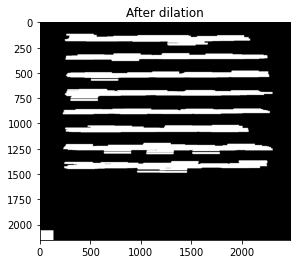

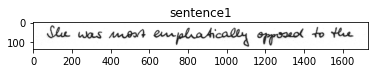

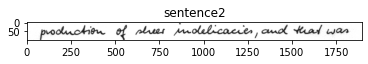

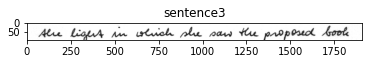

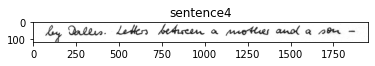

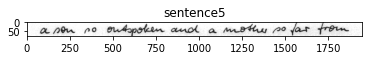

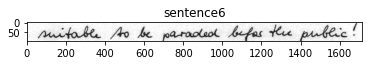

673 2796


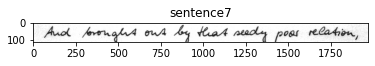

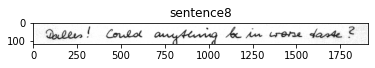

Preprocessing time:1.3582429885864258
[(336, 297, 1805, 21), (338, 698, 1805, 21), (350, 2790, 1805, 21)]
729 2780


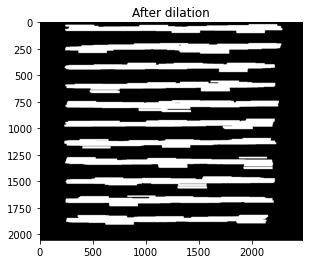

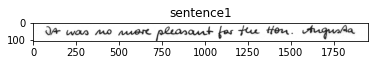

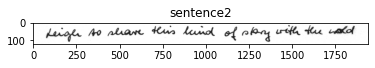

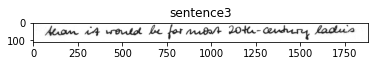

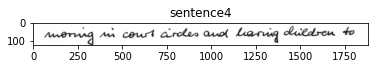

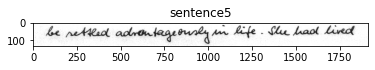

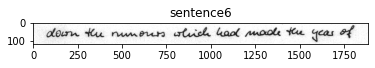

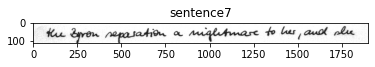

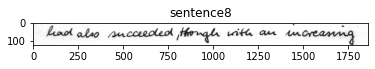

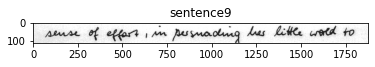

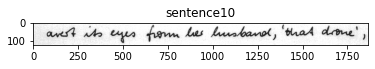

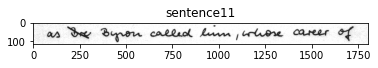

Preprocessing time:1.7074880599975586
[(341, 302, 1801, 17), (342, 603, 1801, 18), (350, 2795, 1802, 16)]
631 2785


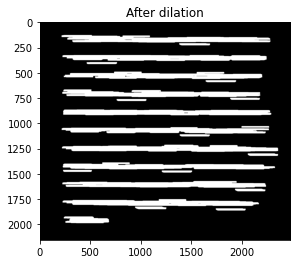

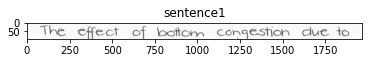

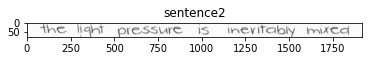

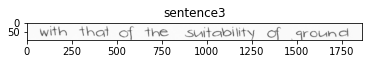

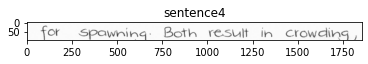

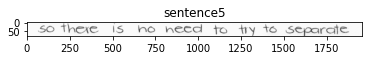

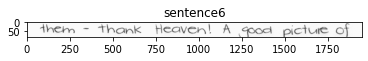

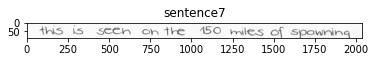

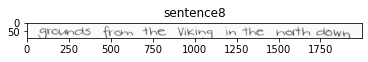

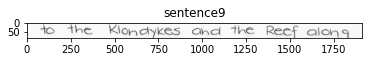

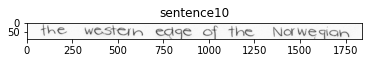

Preprocessing time:1.6048521995544434
[(343, 306, 1801, 17), (344, 607, 1801, 16), (351, 2798, 1801, 15)]
633 2788


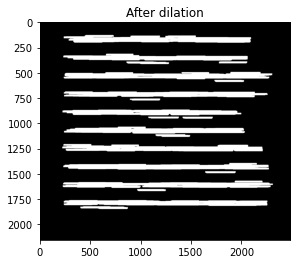

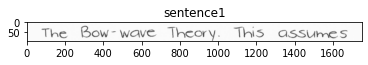

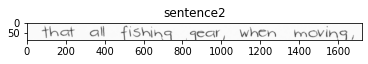

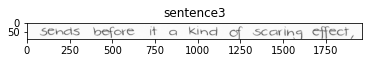

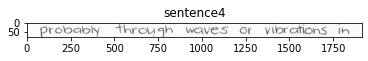

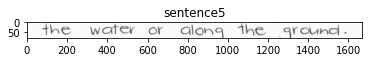

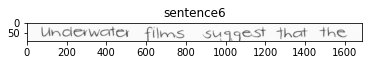

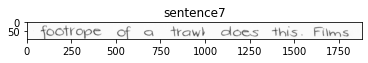

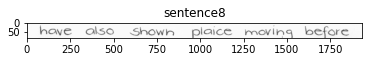

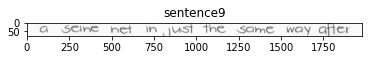

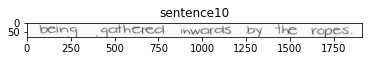

Preprocessing time:1.5962567329406738
[(320, 304, 1801, 16), (320, 605, 1801, 15), (322, 2791, 1800, 16)]
630 2781


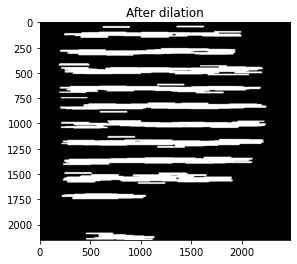

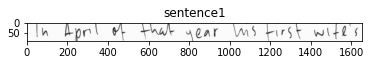

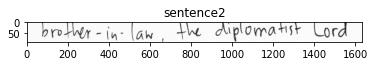

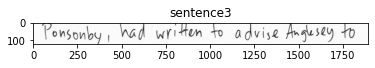

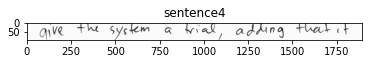

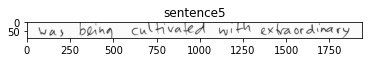

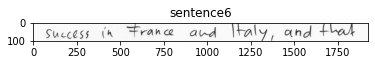

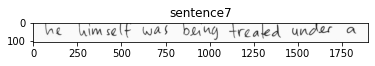

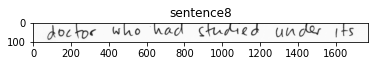

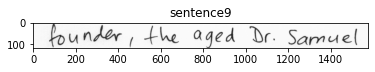

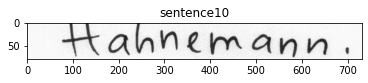

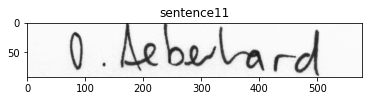

Preprocessing time:1.7529850006103516
[(337, 301, 1802, 15), (337, 600, 1802, 15), (338, 2720, 1801, 83)]
625 2710


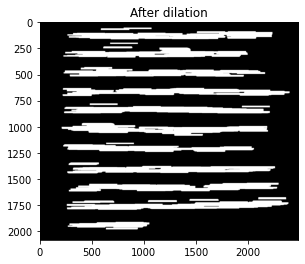

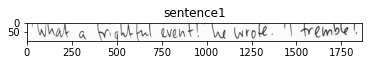

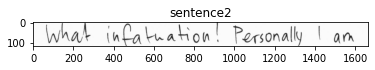

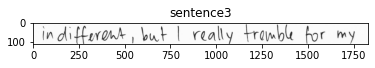

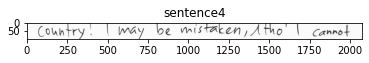

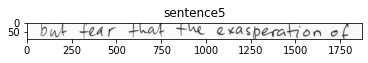

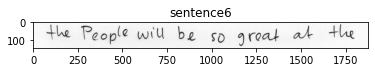

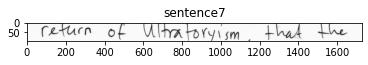

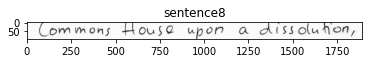

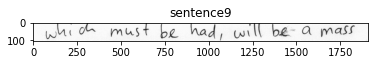

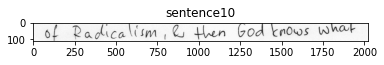

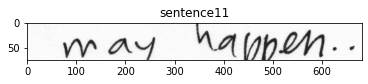

Preprocessing time:1.8898756504058838
[(340, 364, 1799, 22), (342, 713, 1799, 23), (365, 2800, 1798, 28)]
746 2790


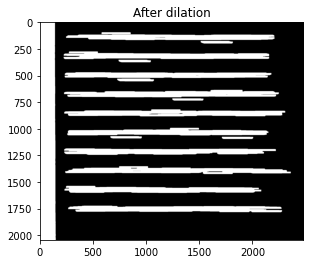

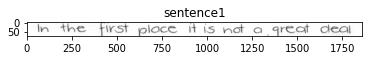

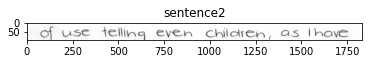

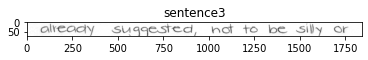

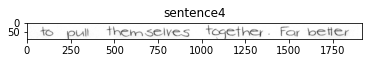

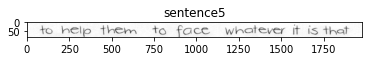

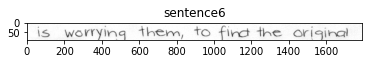

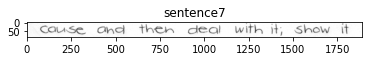

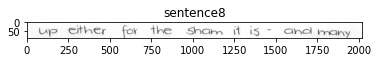

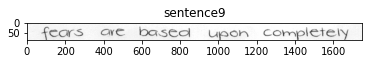

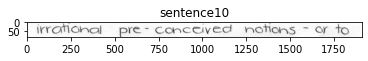

Preprocessing time:1.574359655380249


In [181]:
f_time = open('./output/time.txt', 'w')
f_results = open('./output/results.txt', 'w')

#program main loop
for i in range(78,79):
    path = "./test/"
    temp = "./temp2/"
    print("Test#"+str(i+1))
    if not os.path.exists(temp):
        Path(temp).mkdir(parents=True, exist_ok=True)
        Path(temp + '1/').mkdir(parents=True, exist_ok=True)
        Path(temp + '2/').mkdir(parents=True, exist_ok=True)
        Path(temp + '3/').mkdir(parents=True, exist_ok=True)
    #If folder already exists delete it to generate new test cases
    else:
        shutil.rmtree(temp)
        Path(temp).mkdir(parents=True, exist_ok=True)
        Path(temp + '1/').mkdir(parents=True, exist_ok=True)
        Path(temp + '2/').mkdir(parents=True, exist_ok=True)
        Path(temp + '3/').mkdir(parents=True, exist_ok=True)
        
    if i < 9:
        path = path + str(0) + str(i+1) + "/"
    else:
        path = path + str(i+1) + "/"
        
    w11 = cv2.imread(path + str(1) + "/1.PNG")
    sentences11 = preprocessing(w11)
    w12 = cv2.imread(path + str(1) + "/2.png")
    sentences12 = preprocessing(w12)
    w21 = cv2.imread(path + str(2) + "/1.png")
    sentences21 = preprocessing(w21)
    w22 = cv2.imread(path + str(2) + "/2.png")
    sentences22 = preprocessing(w22)
    w31 = cv2.imread(path + str(3) + "/1.png")
    sentences31 = preprocessing(w31)
    w32 = cv2.imread(path + str(3) + "/2.png")
    sentences32 = preprocessing(w32)

    test_im = cv2.imread(path + "test.png")
    sentences_test = preprocessing(test_im)
    number = 1
    '''
    for sentence in sentences11:
        cv2.imwrite(temp + '1/'+ str(number) + '.PNG', sentence)
        number+=1
    for sentence in sentences12:
        cv2.imwrite(temp + '1/'+ str(number) + '.PNG', sentence)
        number+=1
    number = 1
    for sentence in sentences21:
        cv2.imwrite(temp + '2/'+ str(number) + '.PNG', sentence)
        number+=1
    for sentence in sentences22:
        cv2.imwrite(temp + '2/'+ str(number) + '.PNG', sentence)
        number+=1
    number = 1
    for sentence in sentences31:
        cv2.imwrite(temp + '3/'+ str(number) + '.PNG', sentence)
        number+=1
    for sentence in sentences32:
        cv2.imwrite(temp + '3/'+ str(number) + '.PNG', sentence)
        number+=1
    number = 1
    for sentence in sentences_test:
        cv2.imwrite(temp + 'test'+ str(number) + '.JPG', sentence)
        number+=1

    '''
    
    start_time = time.time()
    #program logic here
      
    end_time = time.time()
    
    f_time.write(str(end_time - start_time) + "\n")
    
f_time.close()
f_results.close()